In [1]:
%connect_info

{
  "key": "3356ab30-aed81f519d7588bd5c0f6707",
  "stdin_port": 48448,
  "ip": "127.0.0.1",
  "control_port": 44076,
  "signature_scheme": "hmac-sha256",
  "kernel_name": "",
  "hb_port": 59098,
  "shell_port": 34219,
  "iopub_port": 40205,
  "transport": "tcp"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-1b0eae4f-27ac-49fd-863c-bbd2f7f6d126.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
import pandas as pd

# Load data


I started out using a bunch of list comprehensions to filter the data, but then I remembered I could use Pandas

```
def get_filename_data():
    filenames = os.listdir(DATA_PATH)
    filenames = [os.path.join(DATA_PATH, fn) for fn in filenames]
    
    _symbol, _category = split_filename(filename)
    if symbol is not None:
        filenames = [f for f in filenames if symbol + '_' in f]
    if category is not None:
        filenames = [f for f in filenames if category in f]
    return [os.path.join(DATA_PATH, fn) for fn in filenames]

```


here's another verson that leverages IPython magic `!ls` to store items in a variable

```
symbol = 'AAPL'

all_files = !ls data_downloader/fundamental/*.csv
curr_file = [f for f in all_files if 'profile' in f and symbol in f]
len(all_files), curr_file
```

In [43]:
df = pd.DataFrame(list(get_filename_data())).set_index(['symbol', 'category'])
ser = df['filename'].head()
pd.Series(ser.to_dict())

ALGN  growth_and_valuation    data_downloader/fundamental/ALGN_growth_and_va...
LUK   todays_trading          data_downloader/fundamental/LUK_todays_trading...
MGM   financials                 data_downloader/fundamental/MGM_financials.csv
SWKS  financials                data_downloader/fundamental/SWKS_financials.csv
VRTX  profile                      data_downloader/fundamental/VRTX_profile.csv
dtype: object

In [497]:
class DataLoader(pd.Series):
    ''''''

          
    @property
    def df(self):
        return Reader(self)
    
    @classmethod
    def from_directory(cls, directory=None):
        df = pd.DataFrame(list(get_filename_data(directory)))
        df.set_index(['symbol', 'category'], inplace=True)
        series_data = df['filename'].to_dict()
        return cls(series_data)

converters = {
    'profile': lambda s: s[['Industry', 'Sector']]
}
from collections import defaultdict
    
    
column_names = {
    'Annual profit (last year)': 'annual_profit',
    'Annual revenue (last year)': 'annual_revenue',
    'Average volume (3 months)': 'average_volume',
    'Day’s range': 'days_range',
    'Dividend yield': 'dividend_yield',
    'EPS forecast (this quarter)': 'eps_forecast',
    'Earnings growth (last year)': 'earnings_growth',
    'Earnings growth (next 5 years)': 'earnings_growth_next_5_yr',
    'Earnings growth (this year)': 'earnings_growth',
    'Industry': 'industry',
    'Last reporting date': 'last_reporting_date',
    'Market cap': 'market_cap',
    'Net profit margin': 'net_profit_margin',
    'Next reporting date': 'next_reporting_date',
    'P/E ratio': 'pe_ratio',
    'Previous close': 'previous_close',
    'Price/Book': 'price_book',
    'Price/Sales': 'price_sales',
    'Revenue growth (last year)': 'revenue_growth',
    'Sector': 'sector',
    'Today’s open': 'todays_open',
    'Volume': 'volume'
}
    
    
    
csv_args = {
    'index_col': ['Symbol'],
#     'names': column_names
}
class Reader:
    def __init__(self, indexer):
        self.indexer = indexer

    def __getitem__(self, *item):
        data_frames = [] # defaultdict(list)
        filenames = self.indexer.loc[item]
        if hasattr(filenames, 'upper'):
            filenames = [filenames]
        for fn in filenames:
            symbol, category = split_filename(fn)
            df = pd.read_csv(fn, **csv_args)
            data_frames.append(df)
        return pd.concat(data_frames, axis=1)
        
#     def __getitem__(self, *item):
#         data_frames = [] # defaultdict(list)
#         filenames = self.indexer.loc[item]
#         if hasattr(filenames, 'upper'):
#             filenames = [filenames]
#         for fn in filenames:
#             symbol, category = split_filename(fn)
#             df = pd.read_csv(fn, **csv_args)
#             series = df_to_series(df)
#             convert_func = converters.get(category, lambda s: s)
#             series = convert_func(series)
#             series['Symbol'] = symbol
#             data_frames.append(series)
#         return pd.DataFrame(data_frames).set_index('Symbol')
    
def df_to_series(df):
    series = df.set_index('0')['1']
    series = series[~series.index.duplicated()]
    return series
    
def fill_with_value(row):
    r = [v for v in row if pd.notnull(v)]
    return r[0] if r else pd.np.nan

def flatten_col(df): 
    return df.apply(func=fill_with_value, axis=0)
    
def flatten(df):
    _df = {}
    for symbol in df.index.values:
        _df[symbol] = flatten_col(df.loc[symbol])
    return pd.DataFrame(_df).transpose()
    

data_files = DataLoader.from_directory()
data_files.df['AAPL']

,Unnamed: 0,Next reporting date,EPS forecast (this quarter),Annual revenue (last year),Annual profit (last year),Net profit margin,Category,Unnamed: 0,Earnings growth (last year),Earnings growth (this year),...,Category,Unnamed: 0,Previous close,Today’s open,Day’s range,Volume,Average volume (3 months),Market cap,Dividend yield,Category
Symbol,,,,,,,,,,,,,,,,,,,,,
AAPL,1,"October 25, 2017",$1.88,$214.2B,$45.7B,21.33%,financials,1,-9.87%,+8.41%,...,profile,1,164.0,164.8,163.63 - 164.94,16591051,27395832,$847.4B,1.54%,todays_trading


In [307]:
frames = data_files.df[:, :]
frames = flatten(frames).rename(columns=column_names)
frames

,annual_profit,annual_revenue,average_volume,days_range,dividend_yield,eps_forecast,earnings_growth,earnings_growth_next_5_yr,earnings_growth,industry,...,net_profit_margin,next_reporting_date,pe_ratio,previous_close,price_book,price_sales,revenue_growth,sector,todays_open,volume
A,$462.0M,$4.2B,1946774,64.21 - 65.18,0.82%,$0.62,+16.67%,+11.79%,+16.75%,Biotechnology,...,10.99%,"November 20, 2017",36.2,64.72,4.92,3.41,+4.06%,Health Technology,64.90,1224667
AAL,$2.7B,$40.2B,5953285,44.65 - 45.47,0.88%,$1.63,-56.55%,-2.80%,-10.43%,Airlines,...,6.66%,"October 27, 2017",11.1,44.74,6.07,0.65,-1.98%,Transportation,44.85,4569439
AAP,$457.7M,$9.6B,1999648,97.65 - 99.43,0.24%,$1.25,-3.12%,+10.00%,-27.09%,Specialty Stores,...,4.78%,"November 9, 2017",19.6,97.90,2.48,1.31,-1.74%,Retail Trade,98.31,1095568
AAPL,$45.7B,$214.2B,27395832,163.63 - 164.94,1.54%,$1.88,-9.87%,+13.50%,+8.41%,Telecommunications Equipment,...,21.33%,"October 25, 2017",18.6,164.00,6.83,2.89,-7.37%,Electronic Technology,164.80,16591051
ABBV,$5.9B,$25.6B,5285143,75.26 - 76.00,3.39%,$1.38,+15.97%,+11.00%,+14.56%,Pharmaceuticals: Major,...,23.10%,"October 27, 2017",18.5,75.30,25.91,3.98,+12.16%,Health Technology,75.59,3831839
ABC,$1.4B,$146.8B,1510122,79.22 - 80.61,1.82%,$1.32,--,+8.00%,+4.66%,Medical Distributors,...,0.97%,"November 2, 2017",20.9,80.25,8.29,0.12,+8.01%,Distribution Services,80.46,1248437
ABT,$1.4B,$20.9B,5859238,50.81 - 51.41,2.07%,$0.65,-47.25%,+11.30%,+13.04%,Medical Specialties,...,5.06%,"October 18, 2017",80.0,50.94,3.67,2.73,+2.20%,Health Technology,51.03,4599498
ACN,$4.1B,$34.8B,1899191,129.87 - 130.95,1.86%,$1.46,+35.50%,+9.91%,+10.41%,Information Technology Services,...,11.82%,"September 28, 2017",23.1,130.76,10.69,2.21,+5.72%,Technology Services,130.95,1528282
ADBE,$1.2B,$5.8B,2212807,154.38 - 156.06,--,$1.01,+87.10%,+17.00%,+34.89%,Packaged Software,...,20.03%,"September 19, 2017",54.0,155.16,10.32,8.62,+23.14%,Technology Services,155.76,1321349
ADI,$861.7M,$3.4B,3398761,83.60 - 85.18,2.13%,$1.14,+25.45%,+11.00%,+49.71%,Semiconductors,...,25.18%,NaN,32.1,83.67,5.03,5.80,-0.40%,Electronic Technology,83.97,2648027


In [ ]:
frames.apply()

In [370]:
index_cols = ['Symbol']
df = pd.read_csv(data_files['JWN', 'profile'], index_col=index_cols)
# df.index = ('a', 'b') # = pd.MultiIndex(levels=['symbol', 'category'], labels=['JWM', 'abc'])
# df.set_index('Symbol')

df2 = pd.read_csv(data_files['JWN', 'financials'], index_col=index_cols)
df3 = pd.read_csv(data_files['AAPL', 'financials'], index_col=index_cols)
pd.concat([df, df2, df3], axis=1)

,Unnamed: 0,Sector,Industry,Co-President & Director,Co-President & Director.1,Corporate headquarters,Category,Unnamed: 0,Next reporting date,EPS forecast (this quarter),...,Annual profit (last year),Net profit margin,Category,Unnamed: 0,Next reporting date,EPS forecast (this quarter),Annual revenue (last year),Annual profit (last year),Net profit margin,Category
AAPL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,"October 25, 2017",$1.88,$214.2B,$45.7B,21.33%,financials
JWN,1.0,Retail Trade,Apparel/Footwear Retail,Peter E. Nordstrom,Erik B. Nordstrom,"Seattle, Washington",profile,1.0,"November 9, 2017",$0.64,...,$354.0M,2.40%,financials,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [356]:
fn = data_files.loc['AAPL', 'profile']
pd.read_csv(fn, squeeze=True)

,Unnamed: 0,0,1,2,3,4,Symbol,Category
0,0,Sector,Industry,Chief Executive Officer & Director,Chief Operating Officer,Corporate headquarters,AAPL,profile
1,1,Electronic Technology,Telecommunications Equipment,Tim Cook,Jeffrey E. Williams,"Cupertino, California",AAPL,profile


In [319]:
df.rename(columns={'1': 'Foo'})
df

,1
0,
Sector,Electronic Technology
Industry,Telecommunications Equipment
Chief Executive Officer & Director,Tim Cook
Chief Operating Officer,Jeffrey E. Williams
Corporate headquarters,"Cupertino, California"


In [315]:

flatten_symbol('AAPL', frames)

TypeError: fill_with_value() got an unexpected keyword argument 'axis'

In [45]:
DATA_PATH = 'data_downloader/fundamental'
import os

def split_filename(filename):
    return tuple(filename.split('/')[-1].replace('.csv', '').split('_', 1))

def get_filename_data(directory=None):
    if directory is None:
        directory = DATA_PATH
    filenames = os.listdir(directory)
    filenames = [os.path.join(DATA_PATH, fn) for fn in filenames]
    
    for fn in filenames:
        symbol, category = split_filename(fn)
        yield {
            'filename': fn,
            'symbol': symbol,
            'category': category,
        }
    

data_files = pd.DataFrame(list(get_filename_data())).set_index(['symbol', 'category'])['filename']

# The beautify of using pandas vs a standard list is the ability to leverage the index for filtering and slicing

In [4]:
data_files.loc['AAPL', 'profile']

'data_downloader/fundamental/AAPL_profile.csv'

In [5]:
data_files.loc[:, 'profile'].head()

symbol
VRTX    data_downloader/fundamental/VRTX_profile.csv
CMI      data_downloader/fundamental/CMI_profile.csv
HES      data_downloader/fundamental/HES_profile.csv
SWK      data_downloader/fundamental/SWK_profile.csv
SIG      data_downloader/fundamental/SIG_profile.csv
Name: filename, dtype: object

In [6]:
data_files.loc['MSFT']

category
growth_and_valuation    data_downloader/fundamental/MSFT_growth_and_va...
profile                      data_downloader/fundamental/MSFT_profile.csv
financials                data_downloader/fundamental/MSFT_financials.csv
todays_trading          data_downloader/fundamental/MSFT_todays_tradin...
Name: filename, dtype: object

In [63]:
symbol = 'AAPL'
prof_df = pd.read_csv(data_files.loc[symbol, 'profile'])
df = prof_df
df

,0,1
0,Sector,Electronic Technology
1,Industry,Telecommunications Equipment
2,Chief Executive Officer & Director,Tim Cook
3,Chief Operating Officer,Jeffrey E. Williams
4,Corporate headquarters,"Cupertino, California"


In [64]:
df = prof_df.set_index('0')
df

,1
0,
Sector,Electronic Technology
Industry,Telecommunications Equipment
Chief Executive Officer & Director,Tim Cook
Chief Operating Officer,Jeffrey E. Williams
Corporate headquarters,"Cupertino, California"


In [10]:
df = df.rename(columns={'1': symbol})
df

,AAPL
0,
Sector,Electronic Technology
Industry,Telecommunications Equipment
Chief Executive Officer & Director,Tim Cook
Chief Operating Officer,Jeffrey E. Williams
Corporate headquarters,"Cupertino, California"


In [11]:
df = df.transpose()
df.index.name = 'Symbol'
df

0,Sector,Industry,Chief Executive Officer & Director,Chief Operating Officer,Corporate headquarters
Symbol,,,,,
AAPL,Electronic Technology,Telecommunications Equipment,Tim Cook,Jeffrey E. Williams,"Cupertino, California"


In [12]:
df.index.name = 'Symbol'

In [13]:
def profile_df(df, symbol=''):
    df = df.set_index('0')
    df = df.rename(columns={'1': symbol})
    df = df.transpose()
    df.index.name = 'Symbol'
    return df
    
profile_df(prof_df, symbol)

0,Sector,Industry,Chief Executive Officer & Director,Chief Operating Officer,Corporate headquarters
Symbol,,,,,
AAPL,Electronic Technology,Telecommunications Equipment,Tim Cook,Jeffrey E. Williams,"Cupertino, California"


# Scratch to see if we can create a dataframe utility that shows how it changes when manipulated

In [14]:
import inspect

In [15]:
inspect.getsourcelines(profile_df)

(["def profile_df(df, symbol=''):\n",
  "    df = df.set_index('0')\n",
  "    df = df.rename(columns={'1': symbol})\n",
  '    df = df.transpose()\n',
  "    df.index.name = 'Symbol'\n",
  '    return df\n'],
 1)

In [16]:
inspect.getsource(profile_df)

"def profile_df(df, symbol=''):\n    df = df.set_index('0')\n    df = df.rename(columns={'1': symbol})\n    df = df.transpose()\n    df.index.name = 'Symbol'\n    return df\n"

In [17]:
df.index.name = 'FOO'

In [18]:
df

0,Sector,Industry,Chief Executive Officer & Director,Chief Operating Officer,Corporate headquarters
FOO,,,,,
AAPL,Electronic Technology,Telecommunications Equipment,Tim Cook,Jeffrey E. Williams,"Cupertino, California"


In [19]:
eval("df.index.name = 'Symbol")

SyntaxError: invalid syntax (<string>, line 1)

In [20]:
exec("    df.index.name = 'Symbol'\n")

IndentationError: unexpected indent (<string>, line 1)

# Load up all the pages

In [21]:
all_profile_files = list(data_files.loc[:, 'profile'])
len(all_profile_files)

501

In [106]:
def filename_to_symbol(filename):
    return filename.split('/')[-1].split('_')[0]

filename_to_symbol(all_profile_files[0])

'AAL'

In [107]:
def get_profile_df(filename):
    symbol = filename_to_symbol(filename)
    df = profile_df(pd.read_csv(filename), symbol)
    return symbol, df

get_df(profile_df, all_profile_files[3])

('ABBV', 0                  Sector                Industry  \
 Symbol                                              
         Health Technology  Pharmaceuticals: Major   
 
 0      Chairman & Chief Executive Officer Senior Vice President-Operations  \
 Symbol                                                                       
                       Richard A. Gonzalez            Azita Saleki-Gerhardt   
 
 0        Corporate headquarters  
 Symbol                           
         North Chicago, Illinois  )

In [108]:
from functools import partial

In [109]:
sp_profile = [get_profile_df(fn)[1] for fn in all_profile_files]

sp_profile[3]

0,Sector,Industry,Chairman & Chief Executive Officer,Senior Vice President-Operations,Corporate headquarters
Symbol,,,,,
ABBV,Health Technology,Pharmaceuticals: Major,Richard A. Gonzalez,Azita Saleki-Gerhardt,"North Chicago, Illinois"


In [110]:
list(sp_profile[0].columns.values)

['Sector',
 'Industry',
 'Chairman & Chief Executive Officer',
 'President',
 'Corporate headquarters']

In [111]:
pd.concat(sp_profile[:5], axis=0)

,Chairman & Chief Executive Officer,"Chairman, President & Chief Executive Officer",Chief Executive Officer & Director,Chief Financial Officer & Executive Vice President,Chief Operating Officer,Corporate headquarters,Industry,President,"President, Chief Executive Officer & Director",Sector,Senior Vice President-Operations
Symbol,,,,,,,,,,,
AAL,Doug Parker,NaN,NaN,NaN,NaN,"Fort Worth, Texas",Airlines,Robert D. Isom,NaN,Transportation,NaN
AAPL,NaN,NaN,Tim Cook,NaN,Jeffrey E. Williams,"Cupertino, California",Telecommunications Equipment,NaN,NaN,Electronic Technology,NaN
AAP,NaN,NaN,NaN,Tom Okray,NaN,"Roanoke, Virginia",Specialty Stores,NaN,Tom Greco,Retail Trade,NaN
ABBV,Richard A. Gonzalez,NaN,NaN,NaN,NaN,"North Chicago, Illinois",Pharmaceuticals: Major,NaN,NaN,Health Technology,Azita Saleki-Gerhardt
ABC,NaN,Steven H. Collis,NaN,Tim G. Guttman,NaN,"Chesterbrook, Pennsylvania",Medical Distributors,NaN,NaN,Distribution Services,NaN


## If we try to merge all the dataframes we get an error

In [112]:
x = pd.concat(sp_profile[260:270], axis=0)

ValueError: Plan shapes are not aligned

# Turns out some columns are duplicates! Pandas doesnt know how to handle this

In [113]:
sp_profile[261]

0,Sector,Industry,Co-President & Director,Co-President & Director,Corporate headquarters
Symbol,,,,,
JWN,Retail Trade,Apparel/Footwear Retail,Peter E. Nordstrom,Erik B. Nordstrom,"Seattle, Washington"


In [122]:
cols = ['Sector', 'Industry']
profiles = pd.concat([df[cols] for df in sp_profile], axis=0)
profiles.head()

0,Sector,Industry
Symbol,,
AAL,Transportation,Airlines
AAPL,Electronic Technology,Telecommunications Equipment
AAP,Retail Trade,Specialty Stores
ABBV,Health Technology,Pharmaceuticals: Major
ABC,Distribution Services,Medical Distributors


# A note about debugging

It's often helpful to work with a smaller dataframe, or a smaller subset of the data

In [115]:
frames = [
    pd.DataFrame({'a': [1], 'b': [2]}),
    pd.DataFrame({'b': [5], 'c': [10]}),
]

pd.concat(frames, axis=0, names=['b'])

,a,b,c
0,1.0,2,NaN
0,NaN,5,10.0


# How many sectors are there in the S&P?

In [124]:
profiles.Sector.describe()

count         501
unique         20
top       Finance
freq           98
Name: Sector, dtype: object

In [142]:
profiles.groupby('Sector').count().sort_values('Industry', ascending=False)

0,Industry
Sector,
Finance,98
Electronic Technology,41
Health Technology,41
Consumer Non-Durables,35
Consumer Services,33
Retail Trade,32
Technology Services,30
Producer Manufacturing,30
Utilities,28


In [143]:
profiles

0,Sector,Industry
Symbol,,
AAL,Transportation,Airlines
AAPL,Electronic Technology,Telecommunications Equipment
AAP,Retail Trade,Specialty Stores
ABBV,Health Technology,Pharmaceuticals: Major
ABC,Distribution Services,Medical Distributors


In [146]:
# The `.where` api isn't the same as filtering, selecting

In [145]:
mask = profiles.Sector == 'Finance'
profiles.where(mask)

0,Sector,Industry
Symbol,,
AAL,NaN,NaN
AAPL,NaN,NaN
AAP,NaN,NaN
ABBV,NaN,NaN
ABC,NaN,NaN
ABT,NaN,NaN
ACN,NaN,NaN
ADBE,NaN,NaN
ADI,NaN,NaN


In [148]:
profiles[mask].head()

0,Sector,Industry
Symbol,,
AFL,Finance,Life/Health Insurance
AIG,Finance,Multi-Line Insurance
AIV,Finance,Real Estate Investment Trusts
AIZ,Finance,Specialty Insurance
AJG,Finance,Insurance Brokers/Services


In [151]:
# What's the difference between these two?

The first one has reset index, the second one doesnt

Why do they give different results.

SyntaxError: invalid syntax (<ipython-input-151-6d9b43e7f563>, line 3)

In [153]:
profiles.reset_index().groupby(['Sector', 'Industry']).count().sort_values('Symbol', ascending=False).head()

,0,Symbol
Sector,Industry,
Finance,Real Estate Investment Trusts,30
Utilities,Electric Utilities,25
Health Technology,Medical Specialties,21
Energy Minerals,Oil & Gas Production,18
Electronic Technology,Semiconductors,11


# Scratch

In [823]:
%matplotlib inline

In [122]:
_df = pd.read_csv('data_downloader/fundamental/JWN_profile.csv')
_df

,0,1
0,Sector,Retail Trade
1,Industry,Apparel/Footwear Retail
2,Co-President & Director,Peter E. Nordstrom
3,Co-President & Director,Erik B. Nordstrom
4,Corporate headquarters,"Seattle, Washington"


In [124]:
s = _df.set_index('0')['1']
s = s[~s.index.duplicated()]
s

0
Sector                                Retail Trade
Industry                   Apparel/Footwear Retail
Co-President & Director         Peter E. Nordstrom
Corporate headquarters         Seattle, Washington
Name: 1, dtype: object

In [106]:
s = pd.Series({'a': 1, 'b': 2, 'a': 3})
s

a    3
b    2
dtype: int64

In [387]:
df1 = pd.DataFrame({'c1': [1, 2, 3], 'c2': [1,2,3]}, index=['r1', 'r2', 'r3'])

df1

,c1,c2
r1,1,1
r2,2,2
r3,3,3


In [410]:
df2 = pd.DataFrame({'c3': [1, 2, 3], 'c4': [1,2,3]}, index=['r1', 'r2', 'r3'])
df2

,c3,c4
r1,1,1
r2,2,2
r3,3,3


In [680]:
df0 = pd.DataFrame()

In [681]:
for d in [df1, df2]:
    df0 = df0.merge(d, how='outer', left_index=True, right_index=True)

In [682]:
ds = [df1, df2]

In [683]:
from itertools import chain

def merge_dataframes(dataframes):
    ds = []
    for fn in dataframes:
        d = pd.read_csv(fn, index_col=['Symbol'])
        ds.append(d)   

    index = list(chain(*map(lambda x: set(x.index.values), ds)))
    columns = list(chain(*map(lambda x: set(x.columns.values), ds)))
    
    df0 = pd.DataFrame(index=set(index), columns=set(columns))

    for d in ds:
        df0.loc[d.index, d.columns] = d
    return df0

df = merge_dataframes(data_files.loc[:])
df.head()

,Chief Financial Officer & VP-Administration,Previous close,"Vice Chairman, President & Chief Operating Officer",No executives to display,Co-President,Chief Operating Officer & Director,"President, Secretary, CAO & General Counsel",Executive Chairman & Chief Technology Officer,President & COO-Americas Mining Division,Executive Vice President-International Operations,...,Chief Technology & Operations Officer,Senior VP-Global Operations & Technology,Chief Operating Officer-Principal Global Investors,Chairman & Chief Creative Officer,Vice President-Worldwide Operations,"EVP, Chief Operating & Financial Officer",COO & Director-San Francisco Regional Market,Senior VP-Global Operations & Customer Services,Chief Financial Officer & EVP-Business Operations,"Chief Financial Officer, Co-Treasurer & EVP"
IBM,NaN,143.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BHGE,NaN,33.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PKG,NaN,112.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VRTX,NaN,160.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Ian F. Smith,NaN,NaN,NaN,NaN
LEG,NaN,45.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [684]:

column_names = {
    'Annual profit (last year)': 'annual_profit',
    'Annual revenue (last year)': 'annual_revenue',
    'Average volume (3 months)': 'average_volume',
    'Day’s range': 'days_range',
    'Dividend yield': 'dividend_yield',
    'EPS forecast (this quarter)': 'eps_forecast',
    'Earnings growth (last year)': 'earnings_growth_last_yr',
    'Earnings growth (next 5 years)': 'earnings_growth_next_5_yr',
    'Earnings growth (this year)': 'earnings_growth_this_yr',
    'Industry': 'industry',
    'Last reporting date': 'last_reporting_date',
    'Market cap': 'market_cap',
    'Net profit margin': 'net_profit_margin',
    'Next reporting date': 'next_reporting_date',
    'P/E ratio': 'pe_ratio',
    'Previous close': 'previous_close',
    'Price/Book': 'price_book',
    'Price/Sales': 'price_sales',
    'Revenue growth (last year)': 'revenue_growth',
    'Sector': 'sector',
    'Today’s open': 'todays_open',
    'Volume': 'volume'
}


def rename_dataframe(df):

    df = df.rename(columns=column_names)
    df = df.loc[:, list(column_names.values())]
    return df

In [744]:
from functools import wraps

def catch(func):
    def wrapper(s):
        if s == '--':
            return pd.np.nan
        try:
            return func(s)
        except Exception as e:
            print("[{}]   {}    {}".format(e, func.__name__, s))
            return pd.np.nan
    
    return wrapper

@catch
def annual_profit(string):
    if string == '--':
        return pd.np.nan
    string = string.replace('$', '')
    amt = string[:-1]
    multiplier = string[-1]
    multiplier = {'M': 1e6,
                  'B': 1e9,
                  'K': 1e3}.get(string[-1], 1)
    
    return float(amt) * multiplier

@catch
def percent(s):
    return float(s.replace('%', ''))

@catch
def plus_minus_percent(s):
    s = s.replace(',', '')
    return float(s[1:-1])

@catch
def dollar_sign(sg):
    lambda s: float(s.replace('$', ''))

column_converters = {
    'annual_profit': annual_profit,
    'annual_revenue': annual_profit,
    'dividend_yield': percent,
    'eps_forecast': dollar_sign,
    'earnings_growth_this_yr': plus_minus_percent,
    'earnings_growth_last_yr': plus_minus_percent,
    'earnings_growth_next_5_yr': plus_minus_percent,
    'market_cap': annual_profit,
    'net_profit_margin': percent,
    'revenue_growth': plus_minus_percent,
    'pe_ratio': catch(float)
}


# for col_name in column_converters.keys():
#     func = column_converters[col_name]
#     column_converters[col_name] = catch(func)

    
def format_columns(df):
    df = df.copy()
    
    for col_name, func in column_converters.items():
        df[col_name] = df[col_name].apply(func)    

    return df

# Some basic analysis

In [746]:
_df = df.copy()
_df = rename_dataframe(_df)
_df = format_columns(_df)
_df.head()

[could not convert string to float: 'NM']   float    NM
[could not convert string to float: 'NM']   float    NM
[could not convert string to float: 'NM']   float    NM
[could not convert string to float: 'NM']   float    NM
[could not convert string to float: 'NM']   float    NM
[could not convert string to float: 'NM']   float    NM
[could not convert string to float: 'NM']   float    NM
[could not convert string to float: 'NM']   float    NM
[could not convert string to float: 'NM']   float    NM
[could not convert string to float: 'NM']   float    NM
[could not convert string to float: 'NM']   float    NM
[could not convert string to float: 'NM']   float    NM
[could not convert string to float: 'NM']   float    NM
[could not convert string to float: 'NM']   float    NM
[could not convert string to float: 'NM']   float    NM
[could not convert string to float: 'NM']   float    NM
[could not convert string to float: 'NM']   float    NM
[could not convert string to float: 'NM']   floa

,pe_ratio,previous_close,annual_profit,average_volume,eps_forecast,todays_open,revenue_growth,net_profit_margin,earnings_growth_last_yr,price_sales,...,sector,annual_revenue,industry,next_reporting_date,dividend_yield,earnings_growth_next_5_yr,price_book,days_range,market_cap,volume
IBM,12.0,143.03,1.190000e+10,4141263,NaN,142.98,2.23,14.87,8.54,1.99,...,Technology Services,7.990000e+10,Information Technology Services,"October 18, 2017",4.16,2.45,7.47,142.98 - 144.50,1.343000e+11,3351733
BHGE,NaN,33.9,-2.700000e+09,3109836,NaN,33.97,37.49,-27.82,40.53,2.87,...,Industrial Services,9.800000e+09,Oilfield Services/Equipment,"October 19, 2017",1.98,33.00,1.15,33.73 - 34.44,3.930000e+10,1724403
PKG,21.9,112.41,4.452000e+08,999133,NaN,112.71,0.65,7.70,6.42,1.38,...,Process Industries,5.800000e+09,Containers/Packaging,"October 16, 2017",2.22,5.00,6.07,112.71 - 113.63,1.070000e+10,434542
VRTX,157.5,160.54,-1.121000e+08,1907935,NaN,160.76,64.89,-6.58,80.09,10.59,...,Health Technology,1.700000e+09,Biotechnology,"October 31, 2017",NaN,68.00,34.83,158.85 - 163.64,4.090000e+10,1708717
LEG,18.4,45.97,3.667000e+08,922679,NaN,46.05,4.07,9.75,16.21,1.82,...,Consumer Durables,3.800000e+09,Home Furnishings,"October 27, 2017",3.10,10.00,5.68,46.05 - 46.53,6.100000e+09,606712


In [747]:
_df.annual_profit.describe()

count    4.980000e+02
mean     1.815594e+09
std      3.945711e+09
min     -6.200000e+09
25%      3.661000e+08
50%      7.285000e+08
75%      1.875000e+09
max      4.570000e+10
Name: annual_profit, dtype: float64

In [748]:
_df.net_profit_margin.describe()

count    497.000000
mean       9.194950
std       17.151145
min     -128.770000
25%        4.570000
50%        9.780000
75%       15.910000
max       81.130000
Name: net_profit_margin, dtype: float64

In [738]:
_df.dividend_yield.describe()

count    419.000000
mean       2.289714
std        1.305051
min        0.020000
25%        1.390000
50%        2.160000
75%        3.010000
max       10.780000
Name: dividend_yield, dtype: float64

In [739]:
_df.query('dividend_yield > 3')

,pe_ratio,previous_close,annual_profit,average_volume,eps_forecast,todays_open,revenue_growth,net_profit_margin,earnings_growth_last_yr,price_sales,...,sector,annual_revenue,industry,next_reporting_date,dividend_yield,earnings_growth_next_5_yr,price_book,days_range,market_cap,volume
IBM,12,143.03,1.190000e+10,4141263,NaN,142.98,2.23,14.87,8.54,1.99,...,Technology Services,7.990000e+10,Information Technology Services,"October 18, 2017",4.16,2.45,7.47,142.98 - 144.50,1.343000e+11,3351733
LEG,18.4,45.97,3.667000e+08,922679,NaN,46.05,4.07,9.75,16.21,1.82,...,Consumer Durables,3.800000e+09,Home Furnishings,"October 27, 2017",3.10,10.00,5.68,46.05 - 46.53,6.100000e+09,606712
MAC,49.8,52.77,1.009000e+08,1378950,NaN,52.98,19.12,9.81,26.75,10.11,...,Finance,1.000000e+09,Real Estate Investment Trusts,"October 31, 2017",5.33,8.00,1.87,52.72 - 53.87,7.500000e+09,1551362
F,11.9,11.03,4.600000e+09,37901668,NaN,11.18,1.50,3.03,37.50,0.32,...,Consumer Durables,1.518000e+11,Motor Vehicles,"October 26, 2017",5.29,8.80,1.57,11.14 - 11.43,4.510000e+10,64560278
HP,NM,42.34,-5.870000e+07,2224789,NaN,42.53,48.69,-3.38,113.95,4.47,...,Industrial Services,1.600000e+09,Contract Drilling,"November 16, 2017",6.51,12.00,1.02,42.16 - 43.19,4.700000e+09,1319461
SLB,372.6,63.51,-1.700000e+09,7326042,NaN,63.2,21.61,-6.07,176.07,4.1,...,Industrial Services,2.780000e+10,Oilfield Services/Equipment,"October 20, 2017",3.16,44.21,2.15,62.97 - 63.92,8.770000e+10,4907449
STX,12.3,31.53,7.720000e+08,5341335,NaN,31.59,3.49,7.17,214.63,1.08,...,Electronic Technology,1.080000e+10,Computer Peripherals,"October 30, 2017",7.92,0.98,6.8,31.55 - 32.02,9.200000e+09,2115257
FRT,41,126.93,2.168000e+08,535401,NaN,127.13,40.51,27.10,16.26,12.62,...,Finance,7.998000e+08,Real Estate Investment Trusts,"November 2, 2017",3.12,6.37,4.69,126.53 - 128.92,9.300000e+09,342348
ETR,NM,79.17,-5.645000e+08,1041756,NaN,79.37,5.16,-5.34,229.29,1.24,...,Utilities,1.060000e+10,Electric Utilities,"October 24, 2017",4.39,4.20,1.76,78.93 - 79.56,1.420000e+10,954671
INTC,13.4,35.07,1.030000e+10,22060314,NaN,35.24,7.28,17.37,9.01,2.98,...,Electronic Technology,5.940000e+10,Semiconductors,"October 27, 2017",3.11,8.08,2.51,35.07 - 35.39,1.649000e+11,12821972


In [769]:
desc = _df.describe().loc['75%'][['dividend_yield', 'pe_ratio', 'revenue_growth']]
desc

dividend_yield     3.010
pe_ratio          32.450
revenue_growth    13.345
Name: 75%, dtype: float64

In [774]:
mask = pd.DataFrame({k: operator.gt(_df[k], v) for k, v in desc.items()})
_df[mask.all(axis=1)].loc[:, ['industry', 'sector']]

,industry,sector
MAC,Real Estate Investment Trusts,Finance
SLB,Oilfield Services/Equipment,Industrial Services
FRT,Real Estate Investment Trusts,Finance
REG,Real Estate Investment Trusts,Finance
IRM,Real Estate Investment Trusts,Finance
SO,Electric Utilities,Utilities
OKE,Oil & Gas Pipelines,Industrial Services
OXY,Oil & Gas Production,Energy Minerals
DLR,Real Estate Investment Trusts,Finance
CVX,Integrated Oil,Energy Minerals


In [752]:
import operator

In [816]:
market_cap = _df.groupby('industry').sum()[['market_cap']]
type(market_cap)
market_cap['percent'] = market_cap['market_cap'] / market_cap['market_cap'].sum() 
market_cap.sort_values('market_cap', inplace=True, ascending=False)
market_cap['cum_sum'] = market_cap['percent'].cumsum()

In [817]:
market_cap.query('cum_sum < .5')

,market_cap,percent,cum_sum
industry,,,
Internet Software/Services,1.172600e+12,0.053669,0.053669
Packaged Software,1.060000e+12,0.048515,0.102184
Pharmaceuticals: Major,1.034600e+12,0.047352,0.149536
Telecommunications Equipment,9.492000e+11,0.043444,0.192980
Major Banks,7.939000e+11,0.036336,0.229316
Medical Specialties,7.127000e+11,0.032619,0.261935
Financial Conglomerates,6.484000e+11,0.029677,0.291612
Electric Utilities,6.392000e+11,0.029255,0.320867
Biotechnology,6.232000e+11,0.028523,0.349391


In [824]:
_df.loc['CVX']

pe_ratio                                 35.3
previous_close                         107.62
annual_profit                       -4.97e+08
average_volume                        5304832
eps_forecast                              NaN
todays_open                            107.68
revenue_growth                          14.78
net_profit_margin                       -0.45
earnings_growth_last_yr                111.02
price_sales                                 2
last_reporting_date                       NaN
earnings_growth_this_yr                266.03
sector                        Energy Minerals
annual_revenue                      1.105e+11
industry                       Integrated Oil
next_reporting_date          November 3, 2017
dividend_yield                           3.97
earnings_growth_next_5_yr                  32
price_book                               1.41
days_range                    107.51 - 109.16
market_cap                          2.061e+11
volume                            

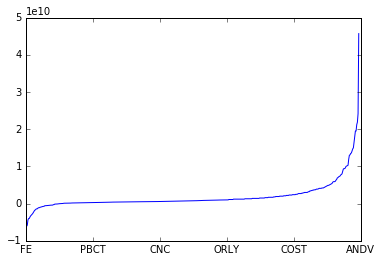

In [825]:
_df.annual_profit.sort_values().plot()

In [826]:
_df[_df.annual_profit > 0].count()

pe_ratio                     434
previous_close               444
annual_profit                444
average_volume               444
eps_forecast                   0
todays_open                  444
revenue_growth               443
net_profit_margin            444
earnings_growth_last_yr      431
price_sales                  444
last_reporting_date            6
earnings_growth_this_yr      439
sector                       444
annual_revenue               444
industry                     444
next_reporting_date          438
dividend_yield               374
earnings_growth_next_5_yr    444
price_book                   444
days_range                   444
market_cap                   444
volume                       444
dtype: int64

In [832]:
_df[_df.annual_profit < 0].reset_index().groupby('industry').count()['index'].sort_values(ascending=False)

industry
Oil & Gas Production                  18
Semiconductors                         4
Oilfield Services/Equipment            4
Electric Utilities                     4
Publishing: Newspapers                 2
Precious Metals                        2
Packaged Software                      2
Trucks/Construction/Farm Machinery     1
Hospital/Nursing Management            1
Apparel/Footwear Retail                1
Biotechnology                          1
Chemicals: Agricultural                1
Containers/Packaging                   1
Contract Drilling                      1
Data Processing Services               1
Miscellaneous Commercial Services      1
Household/Personal Care                1
Integrated Oil                         1
Life/Health Insurance                  1
Specialty Stores                       1
Multi-Line Insurance                   1
Oil & Gas Pipelines                    1
Pharmaceuticals: Other                 1
Real Estate Investment Trusts          1
Aluminu

In [839]:
_df.sort_values('pe_ratio', ascending=False)[['pe_ratio', 'earnings_growth_this_yr']]

,pe_ratio,earnings_growth_this_yr
AES,5333.3,7.36
EQT,2087.0,471.26
CAT,739.3,52.08
APA,658.0,112.68
AIG,505.8,1369.73
MET,490.5,1.64
OXY,398.3,170.44
SLB,372.6,32.58
ARE,275.7,173.35
AIV,250.3,87.08


In [855]:
_df.head()

,pe_ratio,previous_close,annual_profit,average_volume,eps_forecast,todays_open,revenue_growth,net_profit_margin,earnings_growth_last_yr,price_sales,...,sector,annual_revenue,industry,next_reporting_date,dividend_yield,earnings_growth_next_5_yr,price_book,days_range,market_cap,volume
IBM,12.0,143.03,1.190000e+10,4141263,NaN,142.98,2.23,14.87,8.54,1.99,...,Technology Services,7.990000e+10,Information Technology Services,"October 18, 2017",4.16,2.45,7.47,142.98 - 144.50,1.343000e+11,3351733
BHGE,NaN,33.9,-2.700000e+09,3109836,NaN,33.97,37.49,-27.82,40.53,2.87,...,Industrial Services,9.800000e+09,Oilfield Services/Equipment,"October 19, 2017",1.98,33.00,1.15,33.73 - 34.44,3.930000e+10,1724403
PKG,21.9,112.41,4.452000e+08,999133,NaN,112.71,0.65,7.70,6.42,1.38,...,Process Industries,5.800000e+09,Containers/Packaging,"October 16, 2017",2.22,5.00,6.07,112.71 - 113.63,1.070000e+10,434542
VRTX,157.5,160.54,-1.121000e+08,1907935,NaN,160.76,64.89,-6.58,80.09,10.59,...,Health Technology,1.700000e+09,Biotechnology,"October 31, 2017",NaN,68.00,34.83,158.85 - 163.64,4.090000e+10,1708717
LEG,18.4,45.97,3.667000e+08,922679,NaN,46.05,4.07,9.75,16.21,1.82,...,Consumer Durables,3.800000e+09,Home Furnishings,"October 27, 2017",3.10,10.00,5.68,46.05 - 46.53,6.100000e+09,606712


In [882]:
_df2 = _df.copy()
_df2 = _df.unstack().reset_index()
_df2.columns = ['Category', 'Symbol', 'Value']
_df2.fillna(0) #.groupby('Category').apply(lambda ss: ss[ss.Value == ss.Value.max()])

,Category,Symbol,Value
0,pe_ratio,IBM,12
1,pe_ratio,BHGE,0
2,pe_ratio,PKG,21.9
3,pe_ratio,VRTX,157.5
4,pe_ratio,LEG,18.4
5,pe_ratio,KR,13.5
6,pe_ratio,PCLN,39.3
7,pe_ratio,MAC,49.8
8,pe_ratio,F,11.9
9,pe_ratio,WYN,18.6


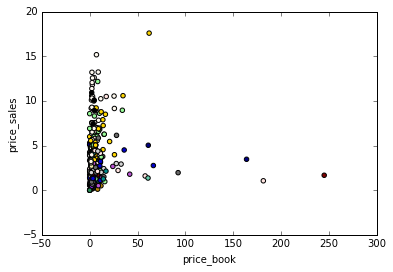

In [952]:
def c(*args):
    print(args)
    return 'red'

from matplotlib import cm
from matplotlib import colors
import random

_d2 = _df[['price_book', 'price_sales', 'sector']]
_d2 = _d2.reset_index()
_d2 = _d2.replace('--', 0)
sector_cm = {s: list(colors.cnames)[i] for i,s in enumerate(_d2.sector.unique())}
c = _d2.sector.apply(lambda s: sector_cm[s])
_d2.plot(x='price_book', y='price_sales', c=c, kind='scatter')

In [947]:
from matplotlib import colors
colors.cnames

<module 'numpy.ma' from '/home/jasonwirth/anaconda3/lib/python3.5/site-packages/numpy/ma/__init__.py'>

In [901]:
cm.cool(10)

(0.039215686274509803, 0.96078431372549022, 1.0, 1.0)

In [897]:
_d2.plot.scatter?

In [881]:
_df.isnull().sum()

pe_ratio                      42
previous_close                 0
annual_profit                  3
average_volume                 0
eps_forecast                 501
todays_open                    0
revenue_growth                 6
net_profit_margin              4
earnings_growth_last_yr       19
price_sales                    0
last_reporting_date          494
earnings_growth_this_yr       10
sector                         0
annual_revenue                 3
industry                       0
next_reporting_date            7
dividend_yield                82
earnings_growth_next_5_yr      3
price_book                     0
days_range                     0
market_cap                     3
volume                         0
dtype: int64